
## Simple 1010 Pattern


In [20]:

# import libraries

import torch
import torch.nn as nn

import pandas
import matplotlib.pyplot as plt
import random
import numpy




## Data Functions


In [21]:

# function to generate real data

def generate_real():
    real_data = torch.FloatTensor(
        [random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2),
         random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2)])
    return real_data
     


In [22]:
generate_real()

tensor([0.8647, 0.1039, 0.8296, 0.1586])

In [23]:

# function to generate uniform random data

def generate_random(size):
    random_data = torch.rand(size)
    return random_data


In [24]:
generate_random(4)

tensor([0.6383, 0.3501, 0.1576, 0.3009])


## Discriminator Network


In [25]:

# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.MSELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass
     



## Train Discriminator on dummy data


In [26]:

# test discriminator can separate real data from random noise

D = Discriminator()

for i in range(10000):
    # real data
    D.train(generate_real(),    torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random(4), torch.FloatTensor([0.0]))
    pass
     


counter =  10000
counter =  20000


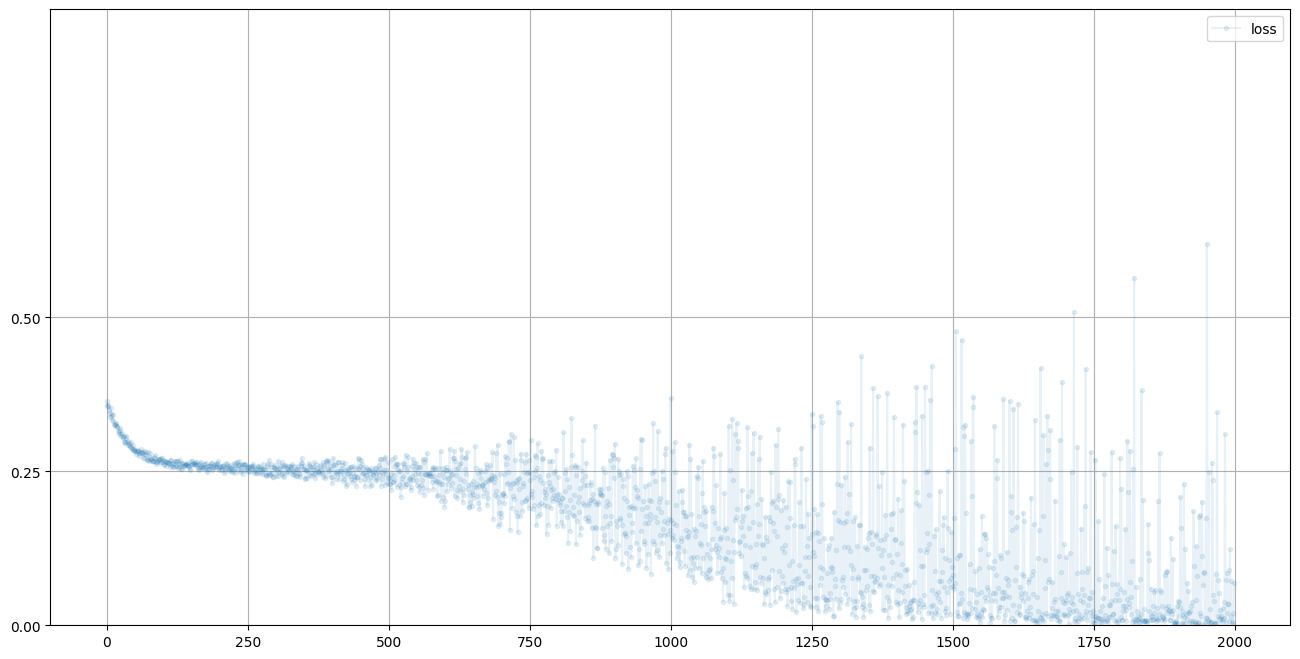

In [27]:

# plot discriminator loss

D.plot_progress()
     



## Test Discriminator on Dummy data


In [29]:

# manually run discriminator to check it can tell real data from fake

print( D.forward( generate_real() ).item() )
print( D.forward( generate_random(4) ).item() )


0.815123438835144
0.3599531054496765



## Generator Network


In [30]:

# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(1, 3),
            nn.Sigmoid(),
            nn.Linear(3, 4),
            nn.Sigmoid()
        )

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass
     



## Test Generator Output


In [32]:

# check the generator output is of the right type and shape
# 0.5 is the noise 

G = Generator()

G.forward(torch.FloatTensor([0.5]))
     


tensor([0.4830, 0.4470, 0.6393, 0.6082], grad_fn=<SigmoidBackward0>)


## Train the GAN


In [33]:

%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator()

image_list = []

# train Discriminator and Generator

for i in range(10000):
    
    # train discriminator on true
    D.train(generate_real(), torch.FloatTensor([1.0]))
    
    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(
        G.forward(   torch.FloatTensor([0.5])   ).detach(), 
        torch.FloatTensor([0.0])
    )
    
    # train generator
    G.train( D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]) )
    
    # add image to list every 1000
    if (i % 1000 == 0):
      image_list.append( G.forward(torch.FloatTensor([0.5])).detach().numpy() )

    pass


counter =  10000
counter =  20000
CPU times: user 8.24 s, sys: 47.6 ms, total: 8.29 s
Wall time: 8.29 s


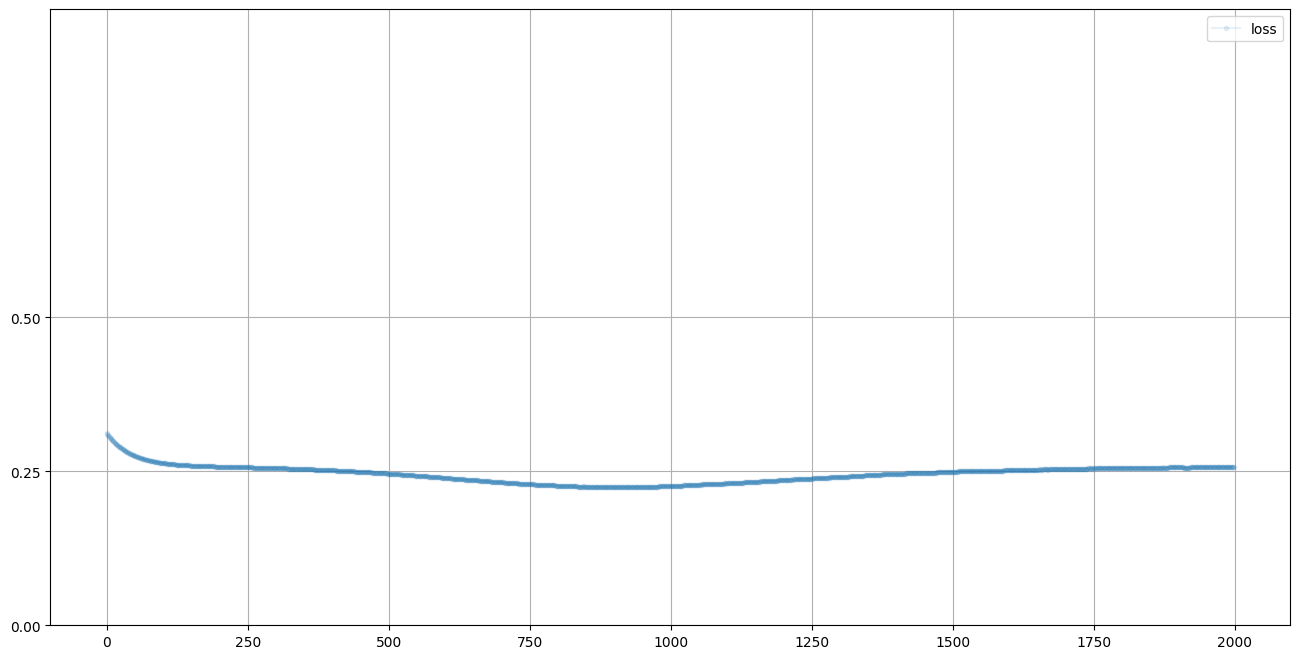

In [34]:

# plot discriminator error

D.plot_progress()


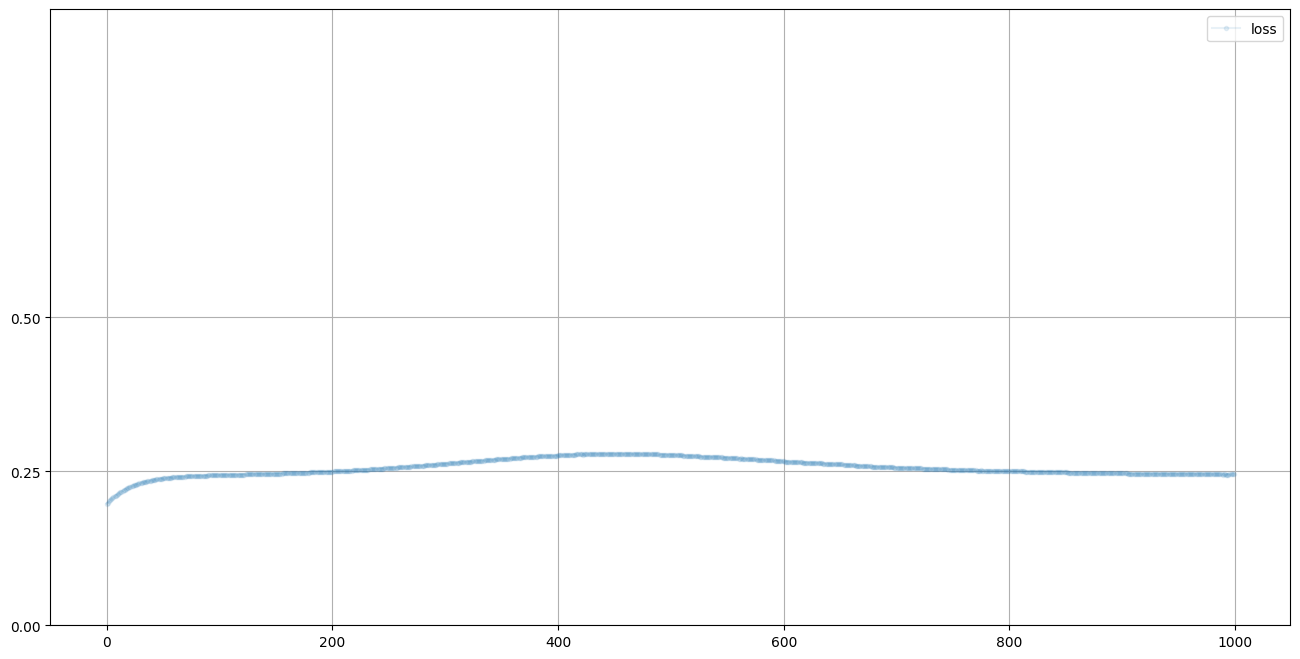

In [35]:

# plot generator error

G.plot_progress()
     



## Manually Run Generator


In [36]:


# manually run generator to see it's outputs

G.forward(torch.FloatTensor([0.5]))


tensor([0.9377, 0.0774, 0.9399, 0.0529], grad_fn=<SigmoidBackward0>)


## Visualise Pattern During Training


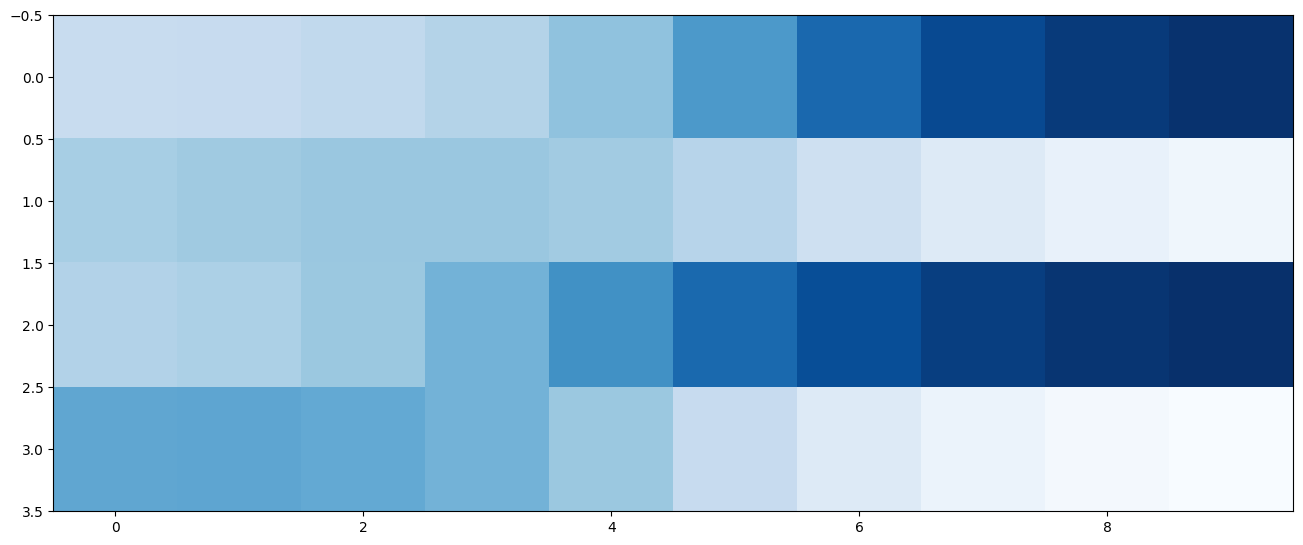

In [37]:

# plot images collected during training

plt.figure(figsize = (16,8))

plt.imshow(numpy.array(image_list).T, interpolation='none', cmap='Blues')
